<a href="https://colab.research.google.com/github/Leonardodaladno1996/Flight-delays-boosting/blob/main/Flight_delays_boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [5]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

In [6]:
train = pd.read_csv(r'/content/gdrive/MyDrive/flight_delays_train.csv')
test = pd.read_csv(r'/content/gdrive/MyDrive/flight_delays_test.csv')

train.head()



,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Month              100000 non-null  object
 1   DayofMonth         100000 non-null  object
 2   DayOfWeek          100000 non-null  object
 3   DepTime            100000 non-null  int64 
 4   UniqueCarrier      100000 non-null  object
 5   Origin             100000 non-null  object
 6   Dest               100000 non-null  object
 7   Distance           100000 non-null  int64 
 8   dep_delayed_15min  100000 non-null  object
dtypes: int64(2), object(7)
memory usage: 6.9+ MB


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Month          100000 non-null  object
 1   DayofMonth     100000 non-null  object
 2   DayOfWeek      100000 non-null  object
 3   DepTime        100000 non-null  int64 
 4   UniqueCarrier  100000 non-null  object
 5   Origin         100000 non-null  object
 6   Dest           100000 non-null  object
 7   Distance       100000 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 6.1+ MB


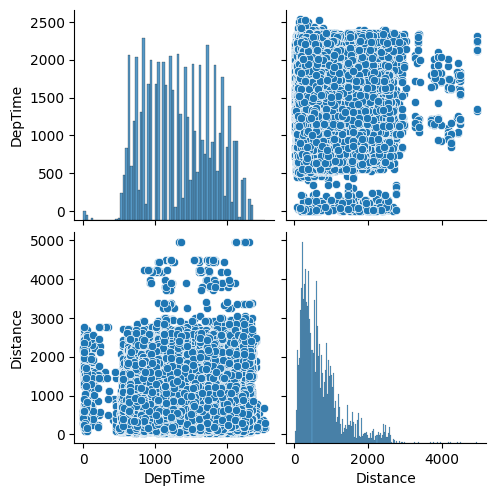

In [9]:
import seaborn as sns

# Построение графиков совместного распределения
sns.pairplot(train[['DepTime', 'Distance']])

In [10]:
train.describe(include=['object'])

,Month,DayofMonth,DayOfWeek,UniqueCarrier,Origin,Dest,dep_delayed_15min
count,100000,100000,100000,100000,100000,100000,100000
unique,12,31,7,22,289,289,2
top,c-8,c-1,c-4,WN,ATL,ATL,N
freq,8830,3399,14736,15082,5834,5795,80956


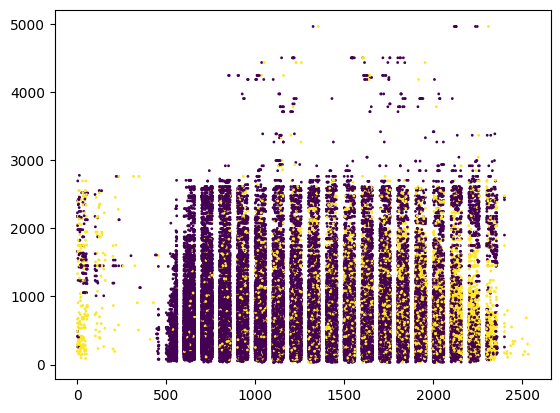

In [16]:
import matplotlib.pyplot as plt

# Построение графика рассеяния для признаков время отправления и длина полета.
# Можно заметить, что количество задержек возрастает в позднее время вылета и при полетах на на дистанции до 3000 км.
plt.scatter(train['DepTime'], train['Distance'], c=train['dep_delayed_15min'].map({'Y': 1, 'N': 0}), s=1)
plt.show()


In [17]:
np.percentile(train['DepTime'].values, [1, 99])

array([ 544., 2252.])

In [18]:
np.percentile(train['Distance'].values, [1, 99])

array([  86., 2556.])

In [19]:
train['DepTime'].min()

1

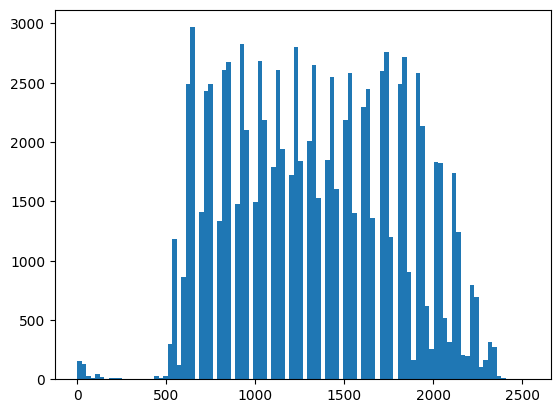

In [20]:
#Гистограмма времени вылетов
plt.hist(train['DepTime'], bins=100)
plt.show()

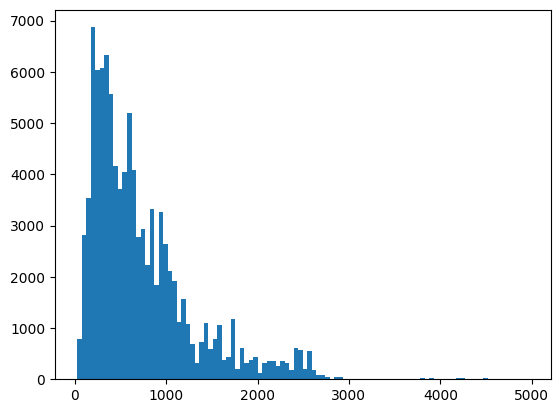

In [22]:
#Гистограма дальности полетов
plt.hist(train['Distance'], bins=100)
plt.show()

In [23]:
X_train, y_train = (
    train[['DepTime', 'Distance']].values,
    train['dep_delayed_15min'].map({'N': 0, 'Y': 1}).values
)

# Разделям выборку на тренировчную и валидационную части.
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=17)

In [24]:
logit = LogisticRegression(random_state=17)

logit.fit(X_train_part, y_train_part)
logit_valid_pred = logit.predict_proba(X_valid)

print(logit_valid_pred[:10], end='\n')

# Значение бейзлана для данной задачи
roc_auc_score(y_valid, logit_valid_pred[:, 1])

[[0.92191495 0.07808505]
 [0.92099624 0.07900376]
 [0.77058061 0.22941939]
 [0.61579088 0.38420912]
 [0.8326264  0.1673736 ]
 [0.67924782 0.32075218]
 [0.83071893 0.16928107]
 [0.7040412  0.2959588 ]
 [0.78419603 0.21580397]
 [0.91861082 0.08138918]]


0.6795697123357751

In [25]:
print(train['DayOfWeek'].unique())
print(train['DayofMonth'].nunique())
print(train['Month'].nunique())
print(train['UniqueCarrier'].nunique())

['c-7' 'c-3' 'c-5' 'c-6' 'c-4' 'c-2' 'c-1']
31
12
22


In [26]:
#Создание нового признака - маршрута
train['Origin'] + pd.Series(["-"] * 100000) + train['Dest']

,0
0,ATL-DFW
1,PIT-MCO
2,RDU-CLE
3,DEN-MEM
4,MDW-OMA
...,...
99995,SFO-RDD
99996,EWR-DAB
99997,DTW-IAH
99998,DFW-GGG


In [27]:
train['Route'] = train['Origin'] + pd.Series(["-"] * 100000) + train['Dest']
test['Route'] = test['Origin'] + pd.Series(["-"] * 100000) + test['Dest']

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Month              100000 non-null  object
 1   DayofMonth         100000 non-null  object
 2   DayOfWeek          100000 non-null  object
 3   DepTime            100000 non-null  int64 
 4   UniqueCarrier      100000 non-null  object
 5   Origin             100000 non-null  object
 6   Dest               100000 non-null  object
 7   Distance           100000 non-null  int64 
 8   dep_delayed_15min  100000 non-null  object
 9   Route              100000 non-null  object
dtypes: int64(2), object(8)
memory usage: 7.6+ MB


In [28]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Month          100000 non-null  object
 1   DayofMonth     100000 non-null  object
 2   DayOfWeek      100000 non-null  object
 3   DepTime        100000 non-null  int64 
 4   UniqueCarrier  100000 non-null  object
 5   Origin         100000 non-null  object
 6   Dest           100000 non-null  object
 7   Distance       100000 non-null  int64 
 8   Route          100000 non-null  object
dtypes: int64(2), object(7)
memory usage: 6.9+ MB


In [29]:
#Проверка значений признака авиаперевозчик для тренировочного и тестового датасета
assert train['UniqueCarrier'].nunique() == test['UniqueCarrier'].nunique(), 'Не совпадение значений авиперевозчиков'





AssertionError: Не совпадение значений авиперевозчиков

In [32]:
#В тестовом датасете меньше уникальных значений признака авиаперевозчик
test['UniqueCarrier'].nunique()

20

In [34]:
assert train['Route'].nunique() == train['Route'].nunique(), 'Не совпадения количестова маршрутов'

In [35]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer()

# Применим One-Hot кодирование для категориальных признаков
one_hot_day_of_week_train = label_binarizer.fit_transform(train['DayOfWeek'].values)
one_hot_day_of_week_test = label_binarizer.transform(test['DayOfWeek'].values)

one_hot_day_of_month_train = label_binarizer.fit_transform(train['DayofMonth'].values)
one_hot_day_of_month_test = label_binarizer.transform(test['DayofMonth'])

one_hot_month_train = label_binarizer.fit_transform(train['Month'])
one_hot_month_test = label_binarizer.transform(test['Month'])

one_hot_carrier_train = label_binarizer.fit_transform(train['UniqueCarrier'])
one_hot_carrier_test = label_binarizer.transform(test['UniqueCarrier'])

one_hot_origin_train = label_binarizer.fit_transform(train['Origin'])
one_hot_origin_test = label_binarizer.transform(test['Origin'])

one_hot_dest_train = label_binarizer.fit_transform(train['Dest'])
one_hot_dest_test = label_binarizer.fit_transform(train['Dest'])

one_hot_route_train = label_binarizer.fit_transform(train['Route'])
one_hot_route_test = label_binarizer.transform(test['Route'])



print(one_hot_route_train.shape)


(100000, 4429)


In [36]:
print(type(one_hot_route_train))

<class 'numpy.ndarray'>


In [37]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Проведем шкалирование числовых признаков, для последуюего применения нейросети
# Для примения бустинга шкалирование не обязательно
train_data_digit = train[['DepTime', 'Distance']].values
test_data_digit = test[['DepTime', 'Distance']].values

train_data_scaled = scaler.fit_transform(train_data_digit)
test_data_scaled = scaler.transform(test_data_digit)

print(train_data_scaled.shape)





(100000, 2)


In [38]:
to_stack_train = [one_hot_day_of_week_train,
                  one_hot_day_of_month_train,
                  one_hot_month_train,
                  one_hot_carrier_train,
                  one_hot_origin_train,
                  one_hot_dest_train]

to_stack_test = [one_hot_day_of_week_test,
                 one_hot_day_of_month_test,
                 one_hot_month_test,
                 one_hot_carrier_test,
                 one_hot_origin_test,
                 one_hot_dest_test]

#Объединим полученные признаки в новые датасеты
for data in to_stack_train:
    train_data_scaled = np.hstack([train_data_scaled, data])


for data in to_stack_test:
    test_data_scaled = np.hstack([test_data_scaled, data])


print(train_data_scaled.shape)
print(test_data_scaled.shape)








(100000, 652)
(100000, 652)


In [39]:
#Получение вектора таргетов
train_labels = train['dep_delayed_15min'].apply(lambda x: 1 if x == 'Y' else 0)
print(np.bincount(train_labels))




[80956 19044]


In [42]:
from scipy.sparse import csr_matrix

#Используем разреженную матрицу для экономии памяти
sparse_train_data = csr_matrix(train_data_scaled)


In [43]:
train_data, valid_data, train_labels, valid_labels = train_test_split(sparse_train_data, train_labels, test_size=0.3, stratify=train_labels)

print(train_data.shape, valid_data.shape)

(70000, 652) (30000, 652)


In [48]:
from warnings import filterwarnings
filterwarnings('ignore')

from sklearn.linear_model import LogisticRegressionCV

logit_cv = LogisticRegressionCV(refit=True)
logit_cv.fit(train_data, train_labels)

valid_preds = logit_cv.predict_proba(valid_data)

#Результат логистической на датасете преобразованных признаков
roc_auc_score(valid_labels, valid_preds[:, 1])







0.7099822487852413

In [49]:
xbg_classifier = XGBClassifier()

dir(xbg_classifier)






['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__sklearn_clone__',
 '__sklearn_is_fitted__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_build_request_for_signature',
 '_can_use_inplace_predict',
 '_check_feature_names',
 '_check_n_features',
 '_configure_fit',
 '_create_dmatrix',
 '_estimator_type',
 '_get_default_requests',
 '_get_iteration_range',
 '_get_metadata_request',
 '_get_param_names',
 '_get_tags',
 '_get_type',
 '_load_model_attributes',
 '_more_tags',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_set_evaluation_result',
 '_validate_data',
 '_validate_params',
 'apply',
 'base_score',
 'best_iteration',
 'best_score',
 'booster',
 'callbacks',
 

In [50]:
xbg_classifier.fit(train_data, train_labels)

valid_preds = xbg_classifier.predict_proba(valid_data)

#Результат бустинга до настройки гиперпараметров
roc_auc_score(valid_labels, valid_preds[:, 1])

0.7402148375466664

In [52]:
#Создание нового признака
short_distance_train = train['Distance'].apply(lambda x: 1 if x <= 1000 else 0).values
late_dep_train = train['DepTime'].apply(lambda x: 1 if x >= 2300 or 0 <= x <= 500 else 0).values

new_train_data_scaled = np.c_[train_data_scaled, short_distance_train, late_dep_train]
print(train_data_scaled.shape, new_train_data_scaled.shape)



(100000, 652) (100000, 654)


In [53]:
new_sparse_data = csr_matrix(new_train_data_scaled)

train_labels = train['dep_delayed_15min'].apply(lambda x: 1 if x == 'Y' else 0)


new_train_data, new_valid_data, train_labels, valid_labels = train_test_split(new_sparse_data, train_labels, test_size=0.3, stratify=train_labels)
print(train_data.shape, valid_data.shape)

from sklearn.linear_model import LogisticRegressionCV

logit_cv = LogisticRegressionCV(refit=True)
logit_cv.fit(new_train_data, train_labels)

valid_preds = logit_cv.predict_proba(new_valid_data)

#Результат логистической регрессии на датасете с новым признаком
roc_auc_score(valid_labels, valid_preds[:, 1])







(70000, 652) (30000, 652)


0.7070029036271293

In [54]:
xgb_classifier = XGBClassifier()

xgb_classifier.fit(new_train_data, train_labels)
valid_preds = xgb_classifier.predict_proba(new_valid_data)

# Результат ненастроенного бустинга на датасете с новым признаком
roc_auc_score(valid_labels, valid_preds[:, 1])

0.7368528374271867

In [55]:
import numpy as np
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

train_labels = train['dep_delayed_15min'].apply(lambda x: 1 if x == 'Y' else 0).values

new_train_data, new_valid_data, train_labels, valid_labels = train_test_split(new_sparse_data, train_labels, test_size=0.3, stratify=train_labels)


# Задаем сетку основных параметров для поиска
param_grid = {
    'max_depth': [3, 4, 5, 6, 7],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_lambda': [0.1, 1, 10],
    'reg_alpha': [0, 0.1, 1, 10]
}

#Для настройки параметров зафиксируем n_estimators на небольшом уровне
xgb_classifier = XGBClassifier(n_estimators=30, use_label_encoder=False, eval_metric='logloss')

#Для быстрого поиска будем использовать RandomSearch
random_search = RandomizedSearchCV(xgb_classifier, param_distributions=param_grid,
                                   n_iter=50, scoring='roc_auc', n_jobs=-1, cv=3, verbose=1, random_state=42)

random_search.fit(new_train_data, train_labels)

#Лучшие параметры
best_params = random_search.best_params_
print("Лучшие параметры сложности модели:", best_params)

# 2. Настроим learning_rate зафиксиров, найденные параметры и установив n_estimators=500

# Обновляем модель с лучшими найденными параметрами
xgb_classifier = XGBClassifier(
    n_estimators=500,  # Фиксируем количество деревьев
    max_depth=best_params['max_depth'],
    colsample_bytree=best_params['colsample_bytree'],
    subsample=best_params['subsample'],
    gamma=best_params['gamma'],
    reg_lambda=best_params['reg_lambda'],
    reg_alpha=best_params['reg_alpha'],
    use_label_encoder=False,
    eval_metric='logloss'
)

#Параметры для поиска оптимального learning_rate
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3]
}

grid_search = GridSearchCV(xgb_classifier, param_grid, scoring='roc_auc', n_jobs=-1, cv=3, verbose=1)
grid_search.fit(new_train_data, train_labels)

#Лучшие параметры
best_learning_rate = grid_search.best_params_['learning_rate']
print("Лучший learning_rate:", best_learning_rate)

#Обучаем модель с найденными параметрами
final_model = XGBClassifier(
    n_estimators=500,
    learning_rate=best_learning_rate,
    max_depth=best_params['max_depth'],
    colsample_bytree=best_params['colsample_bytree'],
    subsample=best_params['subsample'],
    gamma=best_params['gamma'],
    reg_lambda=best_params['reg_lambda'],
    reg_alpha=best_params['reg_alpha'],
    use_label_encoder=False,
    eval_metric='logloss'
)

final_model.fit(new_train_data, train_labels)
valid_preds = final_model.predict_proba(new_valid_data)

#Результат настроенного бустинга
roc_auc = roc_auc_score(valid_labels, valid_preds[:, 1])
print("ROC AUC на валидационной выборке:", roc_auc)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Лучшие параметры сложности модели: {'subsample': 1.0, 'reg_lambda': 10, 'reg_alpha': 1, 'max_depth': 7, 'gamma': 0.3, 'colsample_bytree': 0.6}
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Лучший learning_rate: 0.1
ROC AUC на валидационной выборке: 0.7475510828409649


In [56]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix


#Преобразование данных в тензоры PyTorch
new_train_data = torch.tensor(new_train_data.toarray(), dtype=torch.float32)
new_valid_data = torch.tensor(new_valid_data.toarray(), dtype=torch.float32)
train_labels = torch.tensor(train_labels, dtype=torch.float32).unsqueeze(1)
valid_labels = torch.tensor(valid_labels, dtype=torch.float32).unsqueeze(1)


#Создадим классы датасета
class FlightDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return self.data.size(0)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


train_dataset = FlightDataset(new_train_data, train_labels)
valid_dataset = FlightDataset(new_valid_data, valid_labels)

#Создание итераторов для выгрузки батчей
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

#Определим архитектуру простой полносвязной нейросети
class FlightClassifier(nn.Module):
    def __init__(self, input_dim):
        super(FlightClassifier, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.network(x)


input_dim = new_train_data.size(1)
model = FlightClassifier(input_dim)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

#Используем Binary Crossentropy Loss и оптимизатор Adam
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#Функция обучения модели
def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=50, patience=5):
    best_auc = 0
    epochs_no_improve = 0
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for batch_data, batch_labels in train_loader:
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

            optimizer.zero_grad()
            outputs = model(batch_data)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * batch_data.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)

        #Переключение модели в режим валидации
        model.eval()
        valid_preds = []
        valid_targets = []

        with torch.no_grad():
            for batch_data, batch_labels in valid_loader:
                batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
                outputs = model(batch_data)
                valid_preds.extend(outputs.cpu().numpy())
                valid_targets.extend(batch_labels.cpu().numpy())

        valid_preds = np.array(valid_preds).flatten()
        valid_targets = np.array(valid_targets).flatten()
        roc_auc = roc_auc_score(valid_targets, valid_preds)

        print(f"Эпоха {epoch+1}/{num_epochs} - Потеря: {epoch_loss:.4f} - ROC AUC: {roc_auc:.4f}")

        #Сохранение лучшей модели
        if roc_auc > best_auc:
            best_auc = roc_auc
            epochs_no_improve = 0
            best_model_state = model.state_dict()
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Ранняя остановка!")
                break

    #Загрузка лучшей модели
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model, best_auc

num_epochs = 50
patience = 5

model, best_auc = train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs, patience)
print(f"Лучший ROC AUC на валидационной выборке: {best_auc:.4f}")

#Результаты на валидации
model.eval()
with torch.no_grad():
    valid_preds = []
    for batch_data, _ in valid_loader:
        batch_data = batch_data.to(device)
        outputs = model(batch_data)
        valid_preds.extend(outputs.cpu().numpy())

valid_preds = np.array(valid_preds).flatten()
roc_auc = roc_auc_score(valid_labels.numpy(), valid_preds)
print(f"ROC AUC на валидационной выборке: {roc_auc:.4f}")


Эпоха 1/50 - Потеря: 0.4619 - ROC AUC: 0.7188
Эпоха 2/50 - Потеря: 0.4417 - ROC AUC: 0.7237
Эпоха 3/50 - Потеря: 0.4348 - ROC AUC: 0.7271
Эпоха 4/50 - Потеря: 0.4292 - ROC AUC: 0.7288
Эпоха 5/50 - Потеря: 0.4240 - ROC AUC: 0.7308
Эпоха 6/50 - Потеря: 0.4179 - ROC AUC: 0.7308
Эпоха 7/50 - Потеря: 0.4132 - ROC AUC: 0.7292
Эпоха 8/50 - Потеря: 0.4070 - ROC AUC: 0.7294
Эпоха 9/50 - Потеря: 0.4007 - ROC AUC: 0.7309
Эпоха 10/50 - Потеря: 0.3938 - ROC AUC: 0.7306
Эпоха 11/50 - Потеря: 0.3872 - ROC AUC: 0.7269
Эпоха 12/50 - Потеря: 0.3802 - ROC AUC: 0.7212
Эпоха 13/50 - Потеря: 0.3747 - ROC AUC: 0.7213
Эпоха 14/50 - Потеря: 0.3681 - ROC AUC: 0.7245
Ранняя остановка!
Лучший ROC AUC на валидационной выборке: 0.7309
ROC AUC на валидационной выборке: 0.7245
